In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cython

Note: you may need to restart the kernel to use updated packages.


pip install git+https://github.com/lucasb-eyer/pydensecrf.git

pip install pydensecrf

In [3]:
from skimage import exposure, io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import cv2
import torch
import pywt
from torch import nn
from torchsummary import summary
from torch.optim import SGD
import torch.optim as optim
from tensorflow.keras.utils import array_to_img, img_to_array
from torch.autograd import Variable
from scipy import ndimage
import skimage
from skimage import exposure
from scipy.ndimage import binary_erosion, binary_dilation

# Iterate over the files in the specified directory and its subdirectories
for dirname, _, filenames in os.walk('/kaggle/input/pancreasct-dataset'):
    for filename in filenames:
        # Print the full path of each file
        print(os.path.join(dirname, filename))
filepath="/kaggle/input/pancreasct-dataset"

2024-09-26 13:57:10.931704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 13:57:10.931828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 13:57:11.098595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/pancreasct-dataset/labels/0076.npy
/kaggle/input/pancreasct-dataset/labels/0036.npy
/kaggle/input/pancreasct-dataset/labels/0018.npy
/kaggle/input/pancreasct-dataset/labels/0015.npy
/kaggle/input/pancreasct-dataset/labels/0059.npy
/kaggle/input/pancreasct-dataset/labels/0081.npy
/kaggle/input/pancreasct-dataset/labels/0069.npy
/kaggle/input/pancreasct-dataset/labels/0033.npy
/kaggle/input/pancreasct-dataset/labels/0001.npy
/kaggle/input/pancreasct-dataset/labels/0047.npy
/kaggle/input/pancreasct-dataset/labels/0025.npy
/kaggle/input/pancreasct-dataset/labels/0030.npy
/kaggle/input/pancreasct-dataset/labels/0058.npy
/kaggle/input/pancreasct-dataset/labels/0051.npy
/kaggle/input/pancreasct-dataset/labels/0063.npy
/kaggle/input/pancreasct-dataset/labels/0046.npy
/kaggle/input/pancreasct-dataset/labels/0016.npy
/kaggle/input/pancreasct-dataset/labels/0012.npy
/kaggle/input/pancreasct-dataset/labels/0020.npy
/kaggle/input/pancreasct-dataset/labels/0045.npy
/kaggle/input/pancre

In [5]:
# Initialize empty lists to store file paths
imageFiles = []  # List to store paths of image files
labelFiles = []  # List to store paths of label files
imageFiles = []
labelFiles = []

# Iterate over the files in the specified directory and its subdirectories
for dirname, _, filenames in os.walk(filepath+'/labels'):
    for filename in filenames:
        # Check if the file has the '.npy' extension
        if filename.endswith('.npy'):
            # Append the path of the corresponding image file and label file to their respective lists
            imageFiles.append(os.path.join(filepath+'/images', filename))  # Append image file path
            labelFiles.append(os.path.join(dirname, filename))  # Append label file path

# Remove specific items from the lists
imageFiles.pop(58)
labelFiles.pop(58)

# Print the modified lists
print(imageFiles)  # Print the list of image file paths
print(labelFiles)  # Print the list of label file paths

['/kaggle/input/pancreasct-dataset/images/0076.npy', '/kaggle/input/pancreasct-dataset/images/0036.npy', '/kaggle/input/pancreasct-dataset/images/0018.npy', '/kaggle/input/pancreasct-dataset/images/0015.npy', '/kaggle/input/pancreasct-dataset/images/0059.npy', '/kaggle/input/pancreasct-dataset/images/0081.npy', '/kaggle/input/pancreasct-dataset/images/0069.npy', '/kaggle/input/pancreasct-dataset/images/0033.npy', '/kaggle/input/pancreasct-dataset/images/0001.npy', '/kaggle/input/pancreasct-dataset/images/0047.npy', '/kaggle/input/pancreasct-dataset/images/0025.npy', '/kaggle/input/pancreasct-dataset/images/0030.npy', '/kaggle/input/pancreasct-dataset/images/0058.npy', '/kaggle/input/pancreasct-dataset/images/0051.npy', '/kaggle/input/pancreasct-dataset/images/0063.npy', '/kaggle/input/pancreasct-dataset/images/0046.npy', '/kaggle/input/pancreasct-dataset/images/0016.npy', '/kaggle/input/pancreasct-dataset/images/0012.npy', '/kaggle/input/pancreasct-dataset/images/0020.npy', '/kaggle/in

In [6]:
# Define the depth of the image in pixels
im_depth = 162

# Define the height of the image in pixels
im_height = 300

# Define the width of the image in pixels
im_width = 300

In [7]:
# Declaring an empty NumPy array to store all slices for training images
trainImages = 80-8-8  # Number of training images

# Calculating the number of testing images
testImages = 8

# Calculating the number of validation images
valImages = 8

In [8]:
def remove_background1(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) + (np.std(img1)*0.0))
    threshold1 = (np.mean(img1) + (np.std(img1)*1.5))

    # Apply thresholding to remove background
    if threshold>=0:
        return (((threshold) < img) * ((threshold1) >= img) * (img))+((threshold1 < img)*threshold1)
    else:
        return (((threshold) < img) * ((threshold1) >= img) * (img - threshold))+((threshold1 < img)*(threshold1-threshold))

In [9]:
def remove_background(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) - (np.std(img1)*1.0))

    # Apply thresholding to remove background
    return (((threshold) < img) * (img - threshold))

In [10]:
def remove_background2(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) - (np.std(img1)*3.0))
    threshold1 = (np.mean(img1) + (np.std(img1)*2.0))

    # Apply thresholding to remove background
    if threshold>=0:
        return (((threshold) < img) * ((threshold1) >= img) * (img))+((threshold1 < img)*threshold1)
    else:
        return (((threshold) < img) * ((threshold1) >= img) * (img - threshold))+((threshold1 < img)*(threshold1-threshold))

In [11]:
# Function to normalize image
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    image = ((image - min_val)*2 / (max_val - min_val))-1
    return image,(max_val - min_val)

In [12]:
def process_image(imageFile):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)
    
    #img = np.flip(img, axis=1)

    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()

    # Convert the image array to a PyTorch tensor
    img=np.resize(img, (1, im_depth, im_height, im_width))
    img1=img
    img,val=normalize_image(img)
    
    img=remove_background1(img)
    
    # Apply CLAHE to the 3D image
    clahe = skimage.exposure.equalize_adapthist
    img = clahe(img, clip_limit=2.00)

    return torch.Tensor(img),img1

def process_image(imageFile):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)

    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()

    # Convert the image array to a PyTorch tensor
    img=np.resize(img, (1, im_depth, im_height, im_width))
    img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    clahe = skimage.exposure.equalize_adapthist
    img = clahe(img, clip_limit=0.01)
    img2=img
    img=remove_background1(img)

    img=(img*val).numpy()
    img=np.resize(img, (1,1, im_depth, im_height, im_width))
    img2=np.resize(img2, (1,1, im_depth, im_height, im_width))
    return torch.Tensor(img),torch.Tensor(img2)

In [13]:
# Define the batch size for processing data in mini-batches
BATCH_SIZE = 1

In [14]:
# Load pre-trained models from saved checkpoints
modelx = torch.load('/kaggle/input/final_rcnn/pytorch/default/1/checkpoint_x.pt')
modely = torch.load('/kaggle/input/final_rcnn/pytorch/default/1/checkpoint_y.pt')
modelz = torch.load('/kaggle/input/final_rcnn/pytorch/default/1/checkpoint_z.pt')

/opt/conda/lib/python3.10/site-packages/torch/serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [15]:
# Move the pre-trained models to the GPU for computation
modelx.cuda()
modely.cuda()
modelz.cuda()

RecursiveScriptModule(
  original_name=RCNN
  (bn): RecursiveScriptModule(original_name=BatchNorm3d)
  (a_block1): RecursiveScriptModule(
    original_name=Conv3DBlockn
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (max1): RecursiveScriptModule(original_name=MaxPool3d)
  (a_block2): RecursiveScriptModule(
    original_name=Conv3DBlock
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (max2): RecursiveScriptModule(original_name=MaxPool3d)
  (a_block3): RecursiveScriptModule(
    original_name=Conv3DBlock
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): Recur

In [16]:
# Initialize variables x, y, and z to zero
x = 0
y = 0
z = 0

In [17]:
def process_label(labelFile):
    img = np.load(labelFile)
    #print(img.shape)
    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]
    
    
    #print('label shape',img.shape)
    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the label image array
    image = image.transpose()
    #print('label shape',image.shape)
    
    # Convert the image array to a PyTorch tensor
    img=np.resize(image, (1, 1, im_depth, im_height, im_width))
    
    img= np.array(img, dtype=np.int8)
    return img

In [18]:
def resize_mid(x, val, val2):
    array1 = np.arange(0, val2)
    x = set(x.flatten()*array1)
    x = np.array(list(x))
    print(len(x))
    median_val=np.median(x)
    front=int(median_val-(val/2))
    back=front+val
    
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2):
        front = front - (back - (val2))
        back = val2
    # Check if front index is less than zero, adjust front and back indices accordingly
    elif front < 0:
        back = back - front
        front = 0
    
    return front, back

In [19]:
def cropped_img(x, val, val2):
    array1 = np.arange(0, val2)
    x = set(x.flatten())
    x = np.array(list(x))
    length=len(x)
    median_val=np.median(x)
    front=int(median_val-(length/2))
    back=front+length
    
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2):
        front = front - (back - (val2))
        back = val2
    # Check if front index is less than zero, adjust front and back indices accordingly
    elif front < 0:
        back = back - front
        front = 0
    
    length2 = (val-back+front)/2
    
    
    return length2, front, back

In [20]:
def get_array_output(yhatz,length,length2):
    frontz, backz = resize_mid(yhatz, length, length2)
    output1=np.zeros(length2)
    output2=np.ones(backz-frontz)
    #print("  z:", backz + 1, frontz)
    output1[frontz:backz]=output2
    output1=np.resize(output1,(1,length2))
    #output1 = torch.Tensor(output1)
    #output1 = Variable(output1, requires_grad=True).type(dtype)
    return output1

In [21]:
def clean_array(x,val,val2):
    # Initialize variables to store the indices of the predicted boundary
    #x=x.cpu().detach().numpy()
    #print('clean array',x.shape)
    front = 0
    back = x.shape[1] - 1
    
    # Find the front boundary of the predicted array
    while x[0][front] == 0:
        front = front + 1
        
    # Find the back boundary of the predicted array
    while x[0][back] == 0:
        back = back - 1
    '''back+=20
    front+=20
    if(front<0)
    {
        back-=front
        front=0
    }
    elif(back>=val2)
    {
        front-=back-val2+1
        back=val2-1
    }'''
    l=back-front
    if((val-l)<0):
        l=l-val
        left=0
    else:
        left=((val-l)/2)
        l=0
    # Return the indices of the predicted boundary
    return int(left),int(front+(l/2)), int(back-l+(l/2))

In [22]:
# Define the dimensions of an image volume
im_depth1 = 128   # Depth of the image volume
im_height1 = 208  # Height of the image volume
im_width1 = 128  # Width of the image volume

In [23]:
# Declaring an empty NumPy array to store all slices for training images

# Initializing an empty array with dimensions (trainImages, 1, im_height, im_width, im_depth) filled with zeros and of integer data type
X_train = np.zeros((trainImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_train.shape)  # Print the shape of the array

# Initializing an empty array for training labels with dimensions (trainImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_train = np.zeros((trainImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_train.shape)  # Print the shape of the array

# Declaring an empty NumPy array to store all slices for testing images
X_test = np.zeros((testImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_test.shape)  # Print the shape of the array

# Initializing an empty array for testing labels with dimensions (testImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_test = np.zeros((testImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_test.shape)  # Print the shape of the array

# Declaring an empty NumPy array to store all slices for validation images
X_val = np.zeros((valImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_val.shape)  # Print the shape of the array

# Initializing an empty array for validation labels with dimensions (valImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_val = np.zeros((valImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_val.shape)  # Print the shape of the array

(64, 1, 128, 208, 128)
(64, 1, 128, 208, 128)
(8, 1, 128, 208, 128)
(8, 1, 128, 208, 128)
(8, 1, 128, 208, 128)
(8, 1, 128, 208, 128)


In [24]:
# Define the data type for tensors to be stored on the GPU
dtype = torch.cuda.FloatTensor

In [25]:
li=[]

In [26]:
import scipy.ndimage
import torch.nn.functional as F
def sharpening(img):
    # Define a 3D sharpening kernel
    kernel = np.array([[[ 0,  0,  0],
                        [ 0, -1,  0],
                        [ 0,  0,  0]],

                       [[ 0, -1,  0],
                        [-1,  6, -1],
                        [ 0, -1,  0]],

                       [[ 0,  0,  0],
                        [ 0, -1,  0],
                        [ 0,  0,  0]]])
    kernel_tensor = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sharpened_image = F.conv3d(torch.Tensor(img), kernel_tensor, padding=1)
    return img*(np.array(sharpened_image)<0.8)

In [27]:
clahe = skimage.exposure.equalize_adapthist

In [28]:
# Function to perform DSIHE
def dualistic_sub_image_histogram_equalization(image):
    # Flatten the image to 1D
    flat_image = image.flatten()
    # Calculate the histogram
    hist, bins = np.histogram(flat_image, bins=256, range=[0, 256])
    # Calculate the cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    
    # Find the median of the CDF
    median = np.median(cdf)
    
    # Split the histogram into two sub-histograms
    lower_hist = hist[cdf <= median]
    upper_hist = hist[cdf > median]
    
    # Equalize each sub-histogram
    lower_cdf = lower_hist.cumsum()
    upper_cdf = upper_hist.cumsum()
    
    lower_cdf_normalized = lower_cdf * lower_hist.max() / lower_cdf.max()
    upper_cdf_normalized = upper_cdf * upper_hist.max() / upper_cdf.max()
    
    # Map the original image pixels to the equalized histograms
    equalized_image = np.interp(flat_image, bins[:-1], np.hstack((lower_cdf_normalized, upper_cdf_normalized)))
    
    # Reshape the equalized image back to 3D
    equalized_image = equalized_image.reshape(image.shape)
    
    return equalized_image


In [29]:
def compute_histogram(image):
    # Flatten the 3D image to 1D array and compute the histogram
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0,256])
    return hist

def equalize_histogram(image):
    # Apply OpenCV's equalizeHist to each slice of the 3D image
    eq_image = np.zeros_like(image)
    for i in range(image.shape[0]):  # Iterate through the depth
        eq_image[i] = cv2.equalizeHist(image[i].astype(np.uint8))
    return eq_image

def dualistic_subimage_histogram_equalization(image):
    # Compute histogram of the image
    hist = compute_histogram(image)
    
    # Find the median intensity value
    cdf = hist.cumsum()  # Cumulative distribution function
    total_pixels = cdf[-1]
    median_intensity = np.searchsorted(cdf, total_pixels // 2)
    
    # Split the image based on median intensity
    low_intensity_mask = image <= median_intensity
    high_intensity_mask = image > median_intensity
    
    # Separate the two sub-images
    low_intensity_image = np.copy(image)
    high_intensity_image = np.copy(image)
    
    # Apply mask
    low_intensity_image[~low_intensity_mask] = 0
    high_intensity_image[~high_intensity_mask] = 0
    
    # Apply histogram equalization to both sub-images
    eq_low_intensity_image = equalize_histogram(low_intensity_image)
    eq_high_intensity_image = equalize_histogram(high_intensity_image)
    
    # Combine the two sub-images back
    final_image = np.where(low_intensity_mask, eq_low_intensity_image, eq_high_intensity_image)
    
    return final_image

In [30]:
def contrast_enhancement(image):
    """
    Enhance contrast using CLAHE (Adaptive Histogram Equalization).
    """
    clahe = cv2.createCLAHE(clipLimit=0.001, tileGridSize=(8, 8))
    enhanced_image = np.zeros_like(image, dtype=np.uint8)  # Initialize output image in uint8
    
    for i in range(image.shape[0]):  # Iterate through slices
        # Normalize the slice if it's not already in 8-bit format
        if image[i].dtype != np.uint8:
            norm_slice = cv2.normalize(image[i], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            norm_slice = image[i]
        
        # Apply CLAHE (Adaptive Histogram Equalization) for contrast enhancement
        enhanced_image[i] = clahe.apply(norm_slice)
    
    return enhanced_image

In [31]:
structuring_element = np.ones((3, 3, 3))

In [32]:
loss_checkpoint = 1000
count = 0
loss = 0
val_loss = 0

# Evaluate the model
for i in range(0, trainImages):
    # Process input and label images
    img,img1=process_image(imageFiles[i])
    X=img
    Y = process_label(labelFiles[i])
    Y=Y>0
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    #targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    #lz,frontz, backz=clean_array(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    lz=0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #cfrontz, frontz, backz = cropped_img(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    #lx,frontx, backx=clean_array(yhatx.cpu().detach().numpy(),im_height1,im_height)
    lx=0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #cfrontx, frontx, backx = cropped_img(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    #ly,fronty, backy=clean_array(yhaty.cpu().detach().numpy(),im_width1,im_width)
    ly=0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #cfronty, fronty, backy = cropped_img(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img=np.zeros((1,im_depth1,im_height1,im_width1))
    
    img2=np.zeros((1,im_depth1,im_height1,im_width1))
    
    
    '''print(img1.shape)
    print(y_img.shape)
    print(sum(sum(sum(sum(sum(Y>0))))))
    print(np.max(Y))
    print(np.min(y_img))
    print(np.max(y_img))'''
    
    img1=img1[:,frontz:backz, frontx:backx, fronty:backy]
    y_img=y_img[:,:,frontz:backz, frontx:backx, fronty:backy]
    img1=img1+100
    mask=(img1>0)*(img1<300)
    mask[0]= ndimage.binary_dilation(mask[0], structure=structuring_element).astype(mask.dtype)
    mask[0]= ndimage.binary_erosion(mask[0], structure=structuring_element).astype(mask.dtype)
    mask=mask>0
    
    y_img=y_img*mask
    img1=mask*img1
    
    '''y_img=(img1<50)*(img1>-50)*y_img
    img1=(img1<50)*(img1>-50)*img1
    img1=img1+50'''
    
    img[:,lz:lz+backz-frontz,lx:lx+backx-frontx,ly:ly+backy-fronty] = img1
    img2[:,lz:lz+backz-frontz,lx:lx+backx-frontx,ly:ly+backy-fronty] = y_img[0]
    #img=np.zeros(1,im_depth1,im_height1,im_width1)
    #img[:,frontz-cfrontz:backz+cfrontz, frontx-cfrontx:backx+cfrontx, fronty-cfronty:backy+cfronty] = img1[:,frontz:backz, frontx:backx, fronty:backy]
    #print(img1,yhaty.cpu().detach().numpy()[0])
    #img=img1*yhaty.cpu().detach().numpy()[:,np.newaxis]
    #print(img)
    #img=img.transpose(0,1,3,2)*yhatx.cpu().detach().numpy()[0]
    
    #img=img.transpose(0,2,3,1)*yhatz.cpu().detach().numpy()[0]
    
    #img=img.transpose(0,3,2,1)
    #img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    #img=remove_background2(img)
    #img=(img<50)*(img>-50)*img
    #img,val=normalize_image(img)
    #img=img/val
    #clahe = skimage.exposure.equalize_adapthist
    #img=skimage.exposure.equalize_adapthist(img, kernel_size=None, clip_limit=0.5, nbins=1024)
    #img=remove_background2(img)
    #img=pow(img,2.0)
    #img=sharpening(img)
    #img,val=normalize_image(img)
    img=contrast_enhancement(img[0])
    #img=img[0]
    #img=dualistic_subimage_histogram_equalization(img)
    #img = clahe(img, clip_limit=0.01, kernel_size=3)
    print(np.min(img))
    # Resize and store input images
    X_train[i] = np.resize(img, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_train[i] = np.resize(img2, (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(img2)))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(img2)))) / sum(sum(sum(sum(sum(Y))))))

1 

96
  z: 128
160
   x: 208
119
 y: 128
1
   x: 149    21    x: 243    35    y: 219    91
72003.0    72003    Pancreas percentage: 1.0
2 

107
  z: 128
178
   x: 208
104
 y: 128
1
   x: 129    1    x: 266    58    y: 145    17
111937.0    112025    Pancreas percentage: 0.9992144610577997
3 

103
  z: 128
179
   x: 208
120
 y: 128
1
   x: 162    34    x: 245    37    y: 213    85
87438.0    87441    Pancreas percentage: 0.999965691151748
4 

119
  z: 128
184
   x: 208
125
 y: 128
1
   x: 162    34    x: 253    45    y: 167    39
108065.0    111910    Pancreas percentage: 0.9656420337771423
5 

85
  z: 128
152
   x: 208
103
 y: 128
1
   x: 147    19    x: 241    33    y: 201    73
58897.0    58897    Pancreas percentage: 1.0
6 

108
  z: 128
123
   x: 208
106
 y: 128
1
   x: 141    13    x: 237    29    y: 174    46
58561.0    58571    Pancreas percentage: 0.9998292670434173
7 

100
  z: 128
160
   x: 208
106
 y: 128
1
   x: 158    30    x: 248    40    y: 195    67
118311.0    118311 

In [33]:
np.max(X_train[0])

255.0

In [34]:
np.min(X_train[0])

1.0

<Figure size 8000x5000 with 0 Axes>

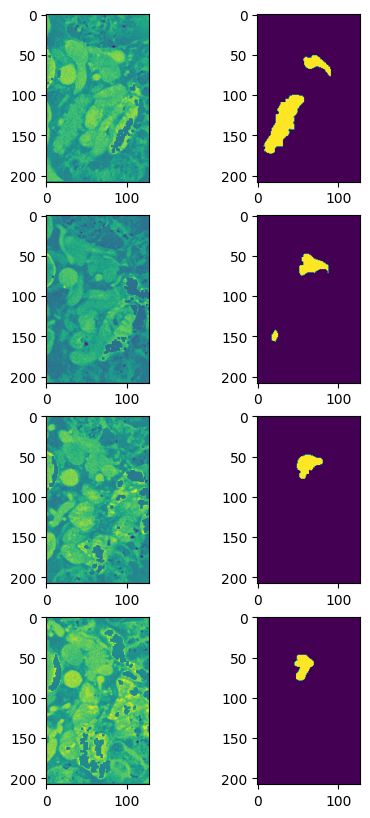

In [35]:
slice_no = [50, 60, 70, 80]

# Create a figure and subplots
plt.figure(figsize=(80, 50))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(5, 10))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_train[0][0][slice_no[i]], (X_train.shape[3], X_train.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_train[0][0][slice_no[i]], (y_train.shape[3], y_train.shape[4], 1)))

In [36]:
# Evaluate the model
for i in range(trainImages, trainImages + testImages):
    # Process input and label images
    img,img1 = process_image(imageFiles[i])
    X = img
    Y = process_label(labelFiles[i])
    Y=Y>0
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    #targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    #lz,frontz, backz=clean_array(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    lz=0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #cfrontz, frontz, backz = cropped_img(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    #lx,frontx, backx=clean_array(yhatx.cpu().detach().numpy(),im_height1,im_height)
    lx=0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #cfrontx, frontx, backx = cropped_img(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    #ly,fronty, backy=clean_array(yhaty.cpu().detach().numpy(),im_width1,im_width)
    ly=0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #cfronty, fronty, backy = cropped_img(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img=np.zeros((1,im_depth1,im_height1,im_width1))
    
    img2=np.zeros((1,im_depth1,im_height1,im_width1))
    
    
    '''print(img1.shape)
    print(y_img.shape)
    print(sum(sum(sum(sum(sum(Y>0))))))
    print(np.max(Y))
    print(np.min(y_img))
    print(np.max(y_img))'''
    
    img1=img1[:,frontz:backz, frontx:backx, fronty:backy]
    y_img=y_img[:,:,frontz:backz, frontx:backx, fronty:backy]
    img1=img1+100
    mask=(img1>0)*(img1<300)
    mask[0]= ndimage.binary_dilation(mask[0], structure=structuring_element).astype(mask.dtype)
    mask[0]= ndimage.binary_erosion(mask[0], structure=structuring_element).astype(mask.dtype)
    mask=mask>0
    
    y_img=y_img*mask
    img1=mask*img1
    
    '''y_img=(img1<50)*(img1>-50)*y_img
    img1=(img1<50)*(img1>-50)*img1
    img1=img1+50'''
    
    img[:,lz:lz+backz-frontz,lx:lx+backx-frontx,ly:ly+backy-fronty] = img1
    img2[:,lz:lz+backz-frontz,lx:lx+backx-frontx,ly:ly+backy-fronty] = y_img[0]
    #img=np.zeros(1,im_depth1,im_height1,im_width1)
    #img[:,frontz-cfrontz:backz+cfrontz, frontx-cfrontx:backx+cfrontx, fronty-cfronty:backy+cfronty] = img1[:,frontz:backz, frontx:backx, fronty:backy]
    #print(img1,yhaty.cpu().detach().numpy()[0])
    #img=img1*yhaty.cpu().detach().numpy()[:,np.newaxis]
    #print(img)
    #img=img.transpose(0,1,3,2)*yhatx.cpu().detach().numpy()[0]
    
    #img=img.transpose(0,2,3,1)*yhatz.cpu().detach().numpy()[0]
    
    #img=img.transpose(0,3,2,1)
    #img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    #img=remove_background2(img)
    #img=(img<50)*(img>-50)*img
    #img,val=normalize_image(img)
    #img=img/val
    #clahe = skimage.exposure.equalize_adapthist
    #img=skimage.exposure.equalize_adapthist(img, kernel_size=None, clip_limit=0.5, nbins=1024)
    #img=remove_background2(img)
    #img=pow(img,2.0)
    #img=sharpening(img)
    #img = clahe(img, clip_limit=2.00, kernel_size=8)
    img=contrast_enhancement(img[0])
    
    # Resize and store input images
    X_test[i-trainImages] = np.resize(img, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_test[i-trainImages] = np.resize(img2, (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(img2)))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(img2)))) / sum(sum(sum(sum(sum(Y))))))
    

65 

114
  z: 128
154
   x: 208
123
 y: 128
   x: 150    22    x: 239    31    y: 190    62
82153.0    82153    Pancreas percentage: 1.0
66 

86
  z: 128
169
   x: 208
110
 y: 128
   x: 141    13    x: 241    33    y: 185    57
103509.0    103509    Pancreas percentage: 1.0
67 

115
  z: 128
169
   x: 208
124
 y: 128
   x: 162    34    x: 240    32    y: 202    74
135109.0    135109    Pancreas percentage: 1.0
68 

102
  z: 128
142
   x: 208
106
 y: 128
   x: 162    34    x: 241    33    y: 169    41
64789.0    64789    Pancreas percentage: 1.0
69 

126
  z: 128
182
   x: 208
109
 y: 128
   x: 158    30    x: 264    56    y: 165    37
101061.0    101061    Pancreas percentage: 1.0
70 

124
  z: 128
168
   x: 208
135
 y: 128
   x: 155    27    x: 229    21    y: 175    47
98882.0    98882    Pancreas percentage: 1.0
71 

87
  z: 128
148
   x: 208
107
 y: 128
   x: 162    34    x: 260    52    y: 160    32
154772.0    154822    Pancreas percentage: 0.999677048481482
72 

112
  z: 128
153

In [37]:
# Evaluate the model
for i in range(trainImages + testImages, trainImages + testImages + valImages):
    # Process input and label images
    img,img1 = process_image(imageFiles[i])
    X = img
    Y = process_label(labelFiles[i])
    Y=Y>0
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    #targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    #lz,frontz, backz=clean_array(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    lz=0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #cfrontz, frontz, backz = cropped_img(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    #lx,frontx, backx=clean_array(yhatx.cpu().detach().numpy(),im_height1,im_height)
    lx=0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #cfrontx, frontx, backx = cropped_img(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    #ly,fronty, backy=clean_array(yhaty.cpu().detach().numpy(),im_width1,im_width)
    ly=0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #cfronty, fronty, backy = cropped_img(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img=np.zeros((1,im_depth1,im_height1,im_width1))
    
    img2=np.zeros((1,im_depth1,im_height1,im_width1))
    
    
    '''print(img1.shape)
    print(y_img.shape)
    print(sum(sum(sum(sum(sum(Y>0))))))
    print(np.max(Y))
    print(np.min(y_img))
    print(np.max(y_img))'''
    
    img1=img1[:,frontz:backz, frontx:backx, fronty:backy]
    y_img=y_img[:,:,frontz:backz, frontx:backx, fronty:backy]
    img1=img1+100
    mask=(img1>0)*(img1<300)
    mask[0]= ndimage.binary_dilation(mask[0], structure=structuring_element).astype(mask.dtype)
    mask[0]= ndimage.binary_erosion(mask[0], structure=structuring_element).astype(mask.dtype)
    mask=mask>0
    y_img=y_img*mask
    img1=mask*img1
    
    '''y_img=(img1<50)*(img1>-50)*y_img
    img1=(img1<50)*(img1>-50)*img1
    img1=img1+50'''
    
    img[:,lz:lz+backz-frontz,lx:lx+backx-frontx,ly:ly+backy-fronty] = img1
    img2[:,lz:lz+backz-frontz,lx:lx+backx-frontx,ly:ly+backy-fronty] = y_img[0]
    #img=np.zeros(1,im_depth1,im_height1,im_width1)
    #img[:,frontz-cfrontz:backz+cfrontz, frontx-cfrontx:backx+cfrontx, fronty-cfronty:backy+cfronty] = img1[:,frontz:backz, frontx:backx, fronty:backy]
    #print(img1,yhaty.cpu().detach().numpy()[0])
    #img=img1*yhaty.cpu().detach().numpy()[:,np.newaxis]
    #print(img)
    #img=img.transpose(0,1,3,2)*yhatx.cpu().detach().numpy()[0]
    
    #img=img.transpose(0,2,3,1)*yhatz.cpu().detach().numpy()[0]
    
    #img=img.transpose(0,3,2,1)
    #img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    #img=remove_background2(img)
    #img=(img<50)*(img>-50)*img
    #img,val=normalize_image(img)
    #img=img/val
    #clahe = skimage.exposure.equalize_adapthist
    #img=skimage.exposure.equalize_adapthist(img, kernel_size=None, clip_limit=0.5, nbins=1024)
    #img=remove_background2(img)
    #img=pow(img,2.0)
    #img=sharpening(img)
    #img = clahe(img, clip_limit=2.00, kernel_size=8)
    img=contrast_enhancement(img[0])
    
    # Resize and store input images
    X_val[i-trainImages-testImages] = np.resize(img, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_val[i-trainImages-testImages] = np.resize(img2, (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(img2)))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(img2)))) / sum(sum(sum(sum(sum(Y))))))
    

73 

88
  z: 128
174
   x: 208
154
 y: 128
   x: 162    34    x: 253    45    y: 212    84
106607.0    107151    Pancreas percentage: 0.9949230525146755
74 

131
  z: 128
134
   x: 208
104
 y: 128
   x: 157    29    x: 236    28    y: 146    18
103344.0    103345    Pancreas percentage: 0.9999903236731337
75 

104
  z: 128
202
   x: 208
130
 y: 128
   x: 154    26    x: 235    27    y: 157    29
79124.0    79155    Pancreas percentage: 0.999608363337755
76 

106
  z: 128
165
   x: 208
120
 y: 128
   x: 162    34    x: 239    31    y: 197    69
94045.0    94045    Pancreas percentage: 1.0
77 

123
  z: 128
152
   x: 208
91
 y: 128
   x: 151    23    x: 250    42    y: 164    36
119997.0    119997    Pancreas percentage: 1.0
78 

109
  z: 128
164
   x: 208
124
 y: 128
   x: 142    14    x: 262    54    y: 217    89
74157.0    74157    Pancreas percentage: 1.0
79 

92
  z: 128
155
   x: 208
119
 y: 128
   x: 162    34    x: 246    38    y: 191    63
136469.0    137409    Pancreas percenta

<Figure size 10000x6000 with 0 Axes>

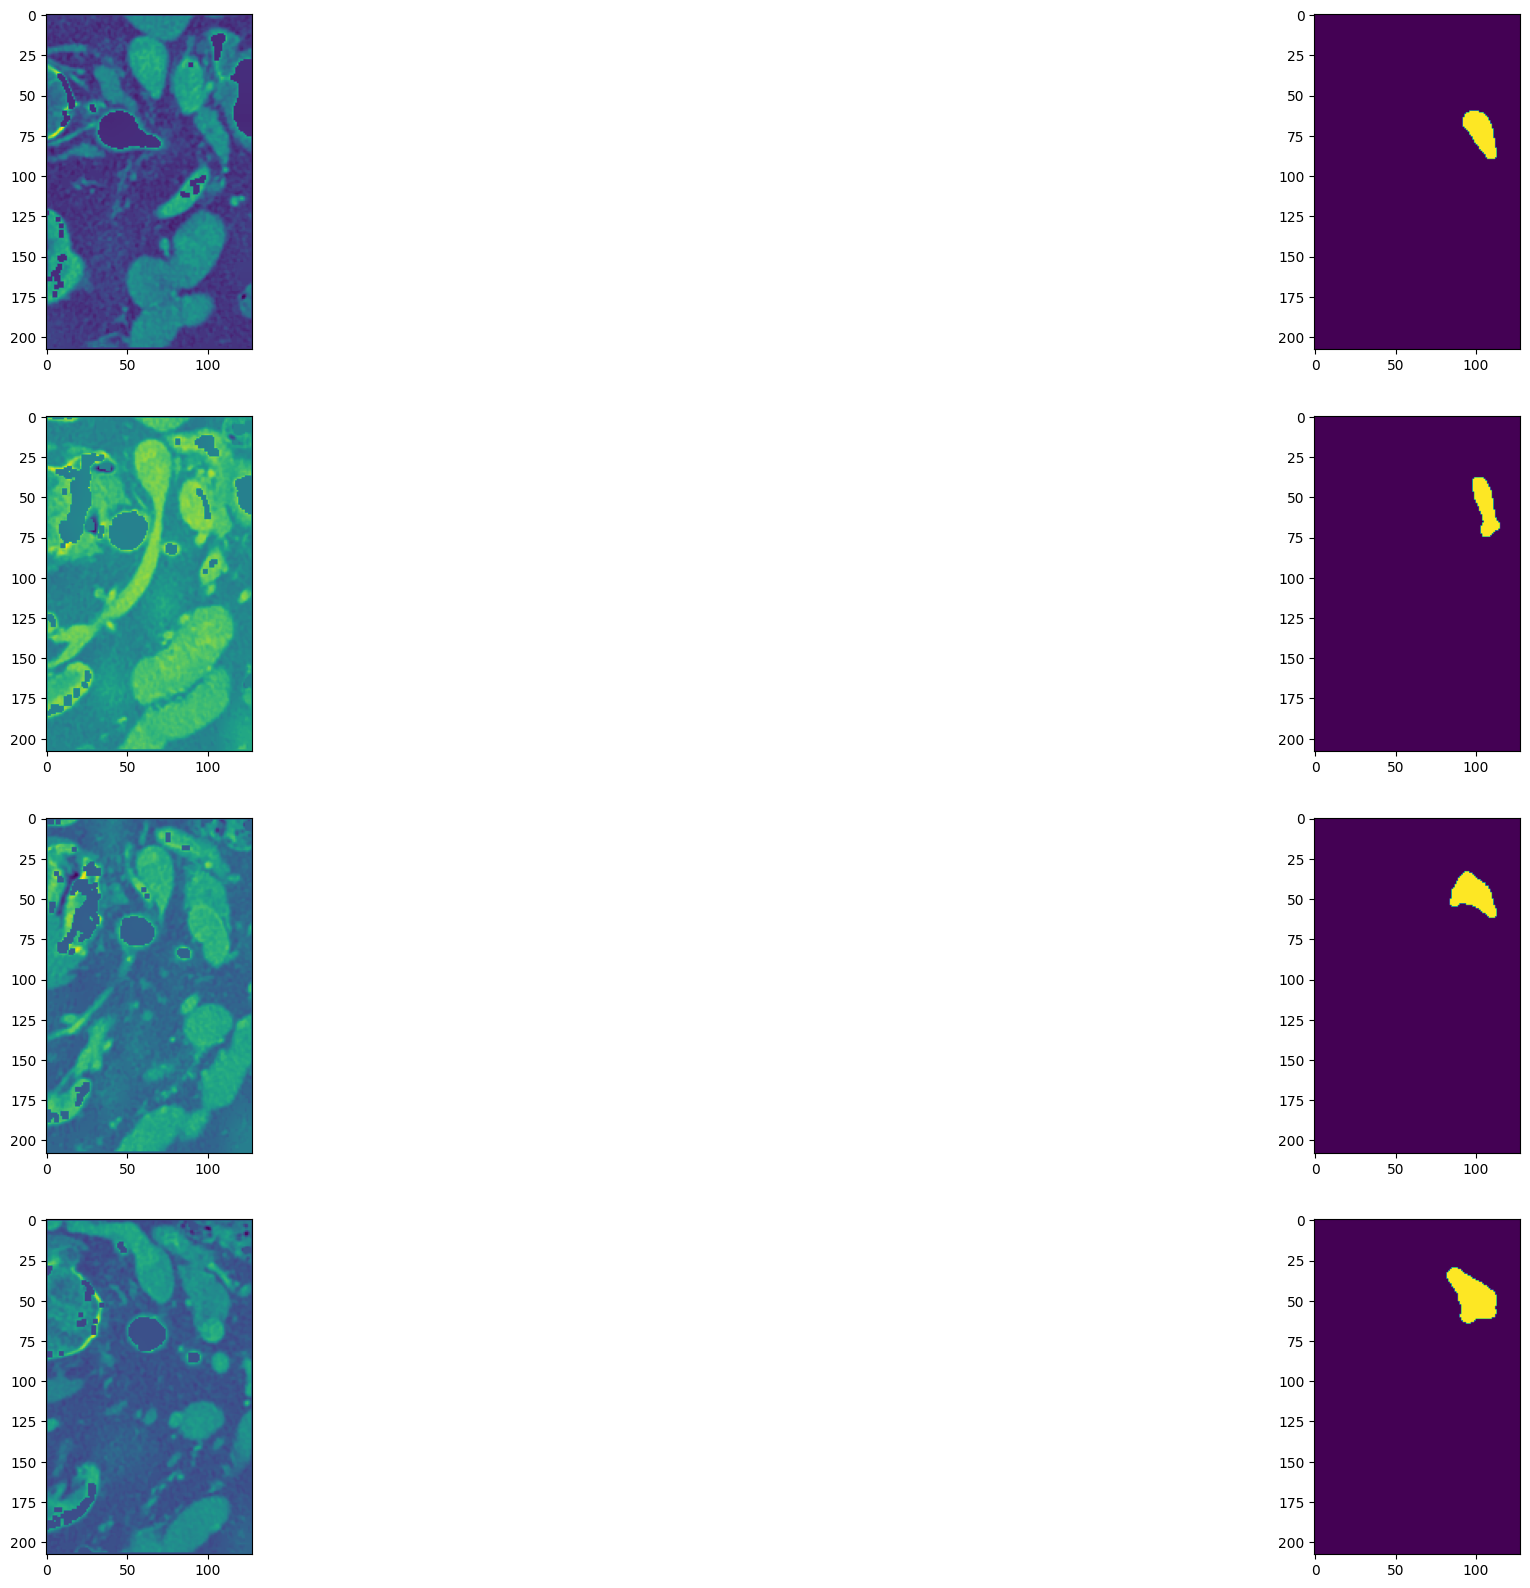

In [38]:
slice_no = [50, 60, 70, 80]
val=2
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

<Figure size 10000x6000 with 0 Axes>

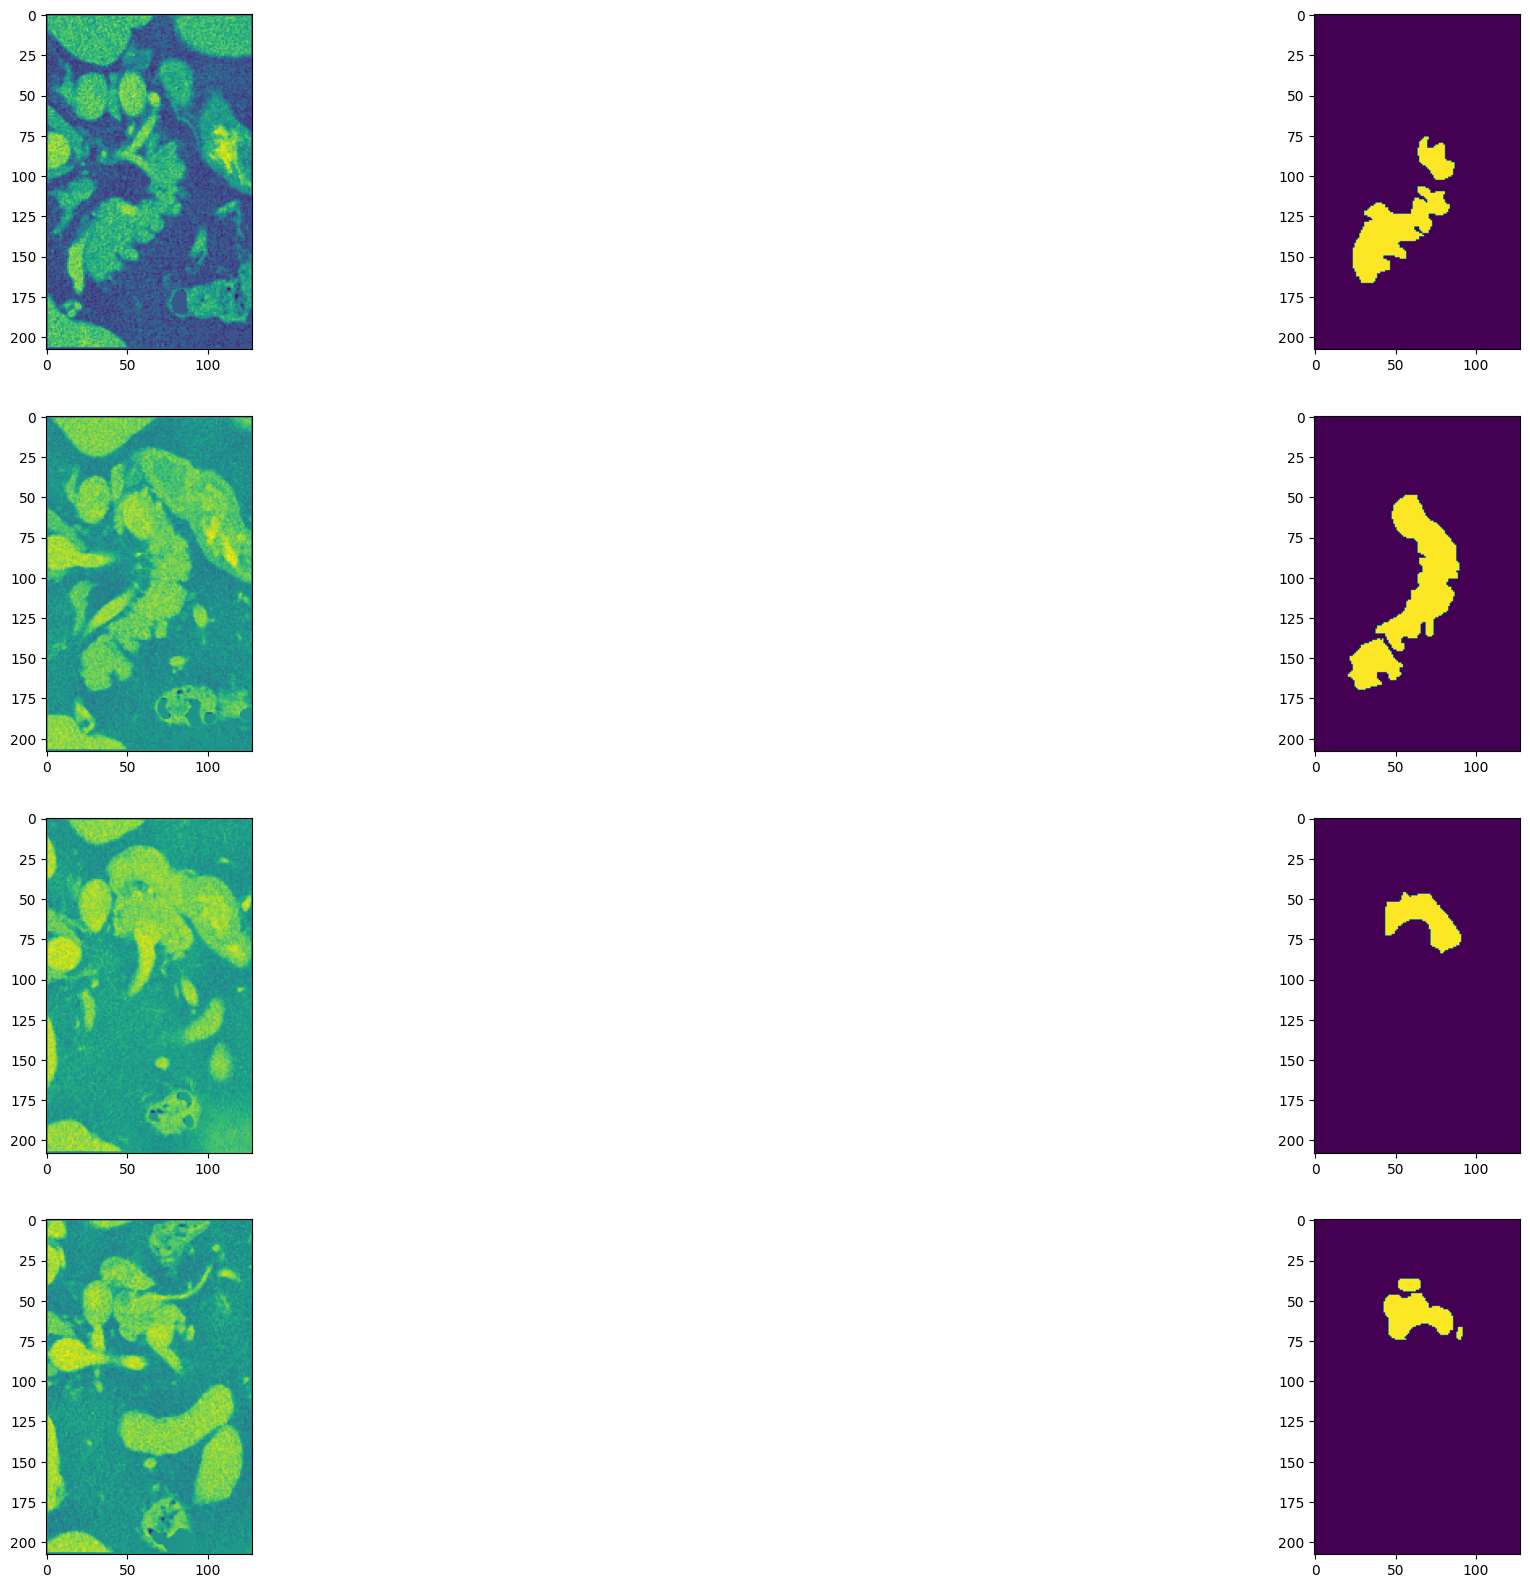

In [39]:
slice_no = [50, 60, 70, 80]
val=3
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

<Figure size 10000x6000 with 0 Axes>

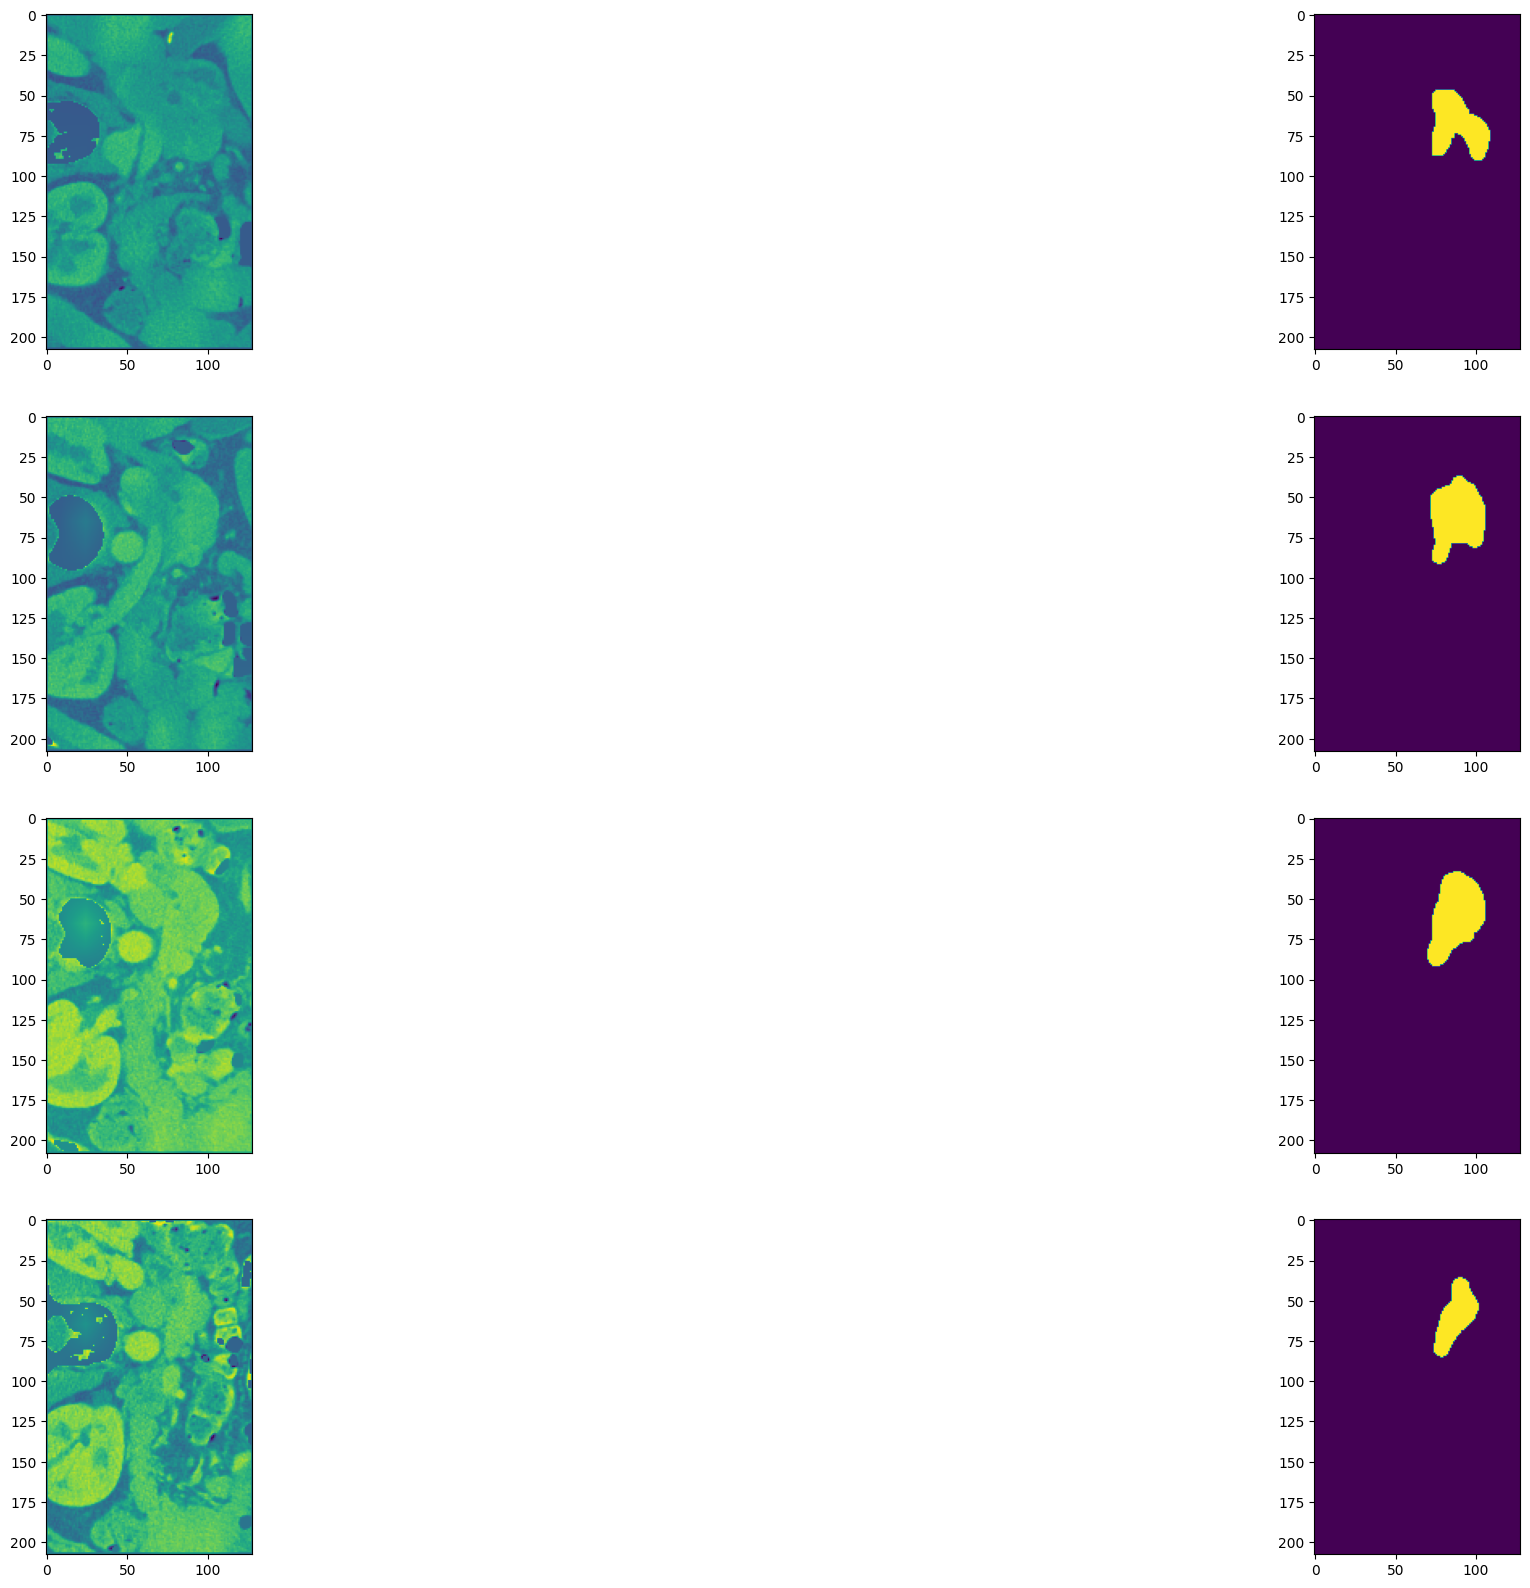

In [40]:
slice_no = [50, 60, 70, 80]
val=4
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

def get_pixels_hu(image):
    #image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    #image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image=image[0]
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(image.shape[0]):
        
        intercept = image[slice_number].RescaleIntercept
        slope = image[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

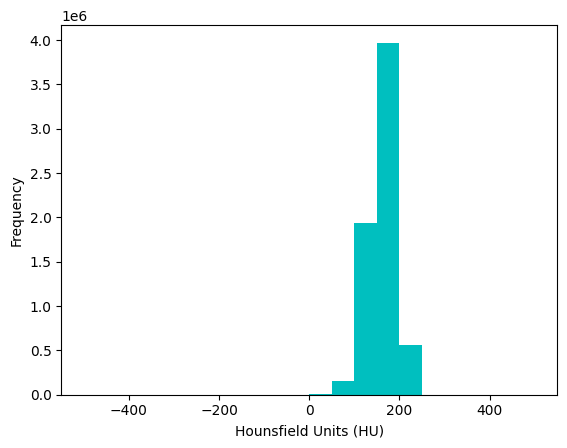

In [41]:
plt.hist((((X_train+2000)*y_train)-2000).flatten(), bins=20, color='c', range=[-500, 500])
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
#plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
#plt.show()

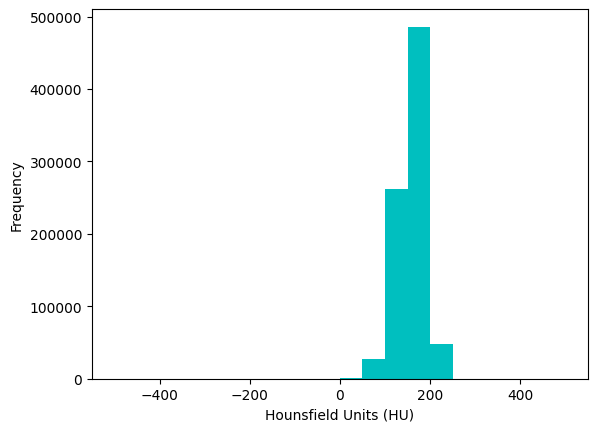

In [42]:
plt.hist((((X_test+2000)*y_test)-2000).flatten(), bins=20, color='c', range=[-500, 500])
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

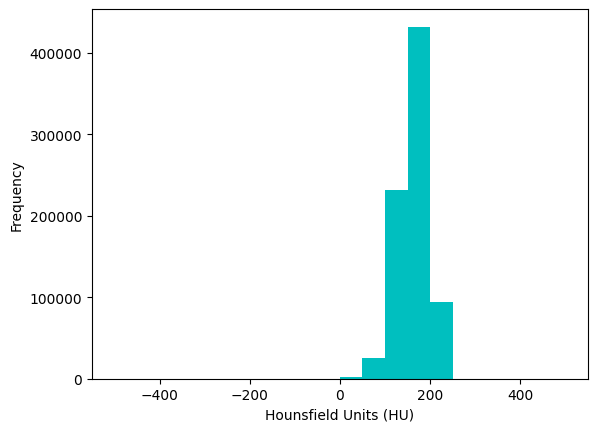

In [43]:
plt.hist((((X_val+2000)*y_val)-2000).flatten(), bins=20, color='c', range=[-500, 500])
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [44]:
# Convert NumPy arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [45]:
class Conv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlock.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Conv3DBlock, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = self.upconv1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1, stride=(1, 1, 1))
        )

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.conv1(input)
        return res

In [46]:
class Conv3DBlockc(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlockc.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Conv3DBlockc, self).__init__()

        # Define the convolutional layers
        self.conv1 = self.upconv1 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(2,2,2),padding=0, stride=(2,2,2)),
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1, stride=1)
        )

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.conv1(input)
        return res

In [47]:
class Residualdense(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlockc.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Residualdense, self).__init__()

        # Define the convolutional layers
        self.block1 = Conv3DBlock(in_channels=in_channels, out_channels=in_channels)
        
        #self.dense_block1 = Conv3DBlock(in_channels=in_channels*2, out_channels=in_channels)
        

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.block1(input)
        
        #res=torch.cat((input,res),1)
        #res= self.dense_block1(res)
        return res

# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Wg and Ws
        self.Wg = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c)
        )
        
        # Define the activation function
        self.relu = nn.ReLU(inplace=True)
        
        # Define the output transformation
        self.output = nn.Sequential(
            nn.Conv3d(out_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        
        # Combine the transformed tensors and apply the activation function
        out = self.relu(Wg + Ws)
        
        # Apply the output transformation and return the result
        out = self.output(out)
        return out * s

In [48]:
# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Wg and Ws
        self.Wg = nn.Sequential(
            nn.Conv3d(in_c*2, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        out = self.Wg(torch.cat((g,s),1))
        
        # Apply the output transformation and return the result
        #out = self.output(out)
        return out*g

# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Ws
        self.Ws = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c),
            nn.LeakyReLU(0.2)
        )

    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        Ws = self.Ws(s)
        
        return Ws

In [49]:
# Define an upsampling convolutional block module
class UPConv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlock, self).__init__()

        # Define the layers of the upsampling convolutional block
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [50]:
# Define an upsampling convolutional block module with trilinear interpolation
class UPConv3DBlockc(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlockc, self).__init__()

        # Define the layers of the upsampling convolutional block with trilinear interpolation
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [51]:
# Define an upsampling convolutional block module with trilinear interpolation
class UPConv3DBlockc2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlockc2, self).__init__()

        # Define the layers of the upsampling convolutional block with trilinear interpolation
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=(2,2,1), mode='trilinear', align_corners=True),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [52]:
# Define the UNet3D model
class UNET3D(nn.Module):
    # Define model elements
    def __init__(self, in_channels, out_channels):
        super(UNET3D, self).__init__()
        level = [4,8,16,32, 64, 128, 256]
        
        # Input batch normalization layer
        self.in1 = nn.BatchNorm3d(in_channels)
        
        # Encoding blocks
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level[1])
        #self.d_block1 = Residualdense(in_channels=level[0], out_channels=level[0])
        
        # Linear block
        #self.lin1 = nn.Linear(im_depth1 ,im_depth1)
        #self.lin2 = nn.Linear(im_height1 ,im_height1)
        #self.lin3 = nn.Linear(im_width1 ,im_width1)
        
        # Pooling blocks
        self.p_block1 = Conv3DBlockc(in_channels=level[1], out_channels=level[2])
        #self.d_block2 = Residualdense(in_channels=level[1], out_channels=level[1])
        
        self.p_block2 = Conv3DBlockc(in_channels=level[2], out_channels=level[3])
        #self.d_block3 = Residualdense(in_channels=level[2], out_channels=level[2])
        
        # Dropout layers
        self.drop = nn.Dropout(0.3)
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.3)
        self.drop3 = nn.Dropout(0.3)
        self.drop4 = nn.Dropout(0.3)
        
        # Decoding blocks
        self.b_block1 = UPConv3DBlock(in_channels=level[3], out_channels=level[3])
        
        
        self.u_block2 = UPConv3DBlockc(in_channels=level[3], out_channels=level[2])
        self.att2 = attention_gate(level[2], level[2])
        
        self.u_block3 = UPConv3DBlockc(in_channels=level[2], out_channels=level[1])
        self.att3 = attention_gate(level[1], level[1])
        
        # Final decoding blocks
        self.b_block4 = UPConv3DBlockc2(in_channels=level[1], out_channels=level[0])
        #self.d_block5 = Residualdense(in_channels=level[0], out_channels=level[0])
        
        # Final convolution and sigmoid activation
        self.b_block6 = UPConv3DBlock(in_channels=level[0], out_channels=level[0])
        self.out = nn.Conv3d(in_channels=level[0], out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        self.sigmoid_layer = nn.Sigmoid()
    
    # Forward propagate input
    def forward(self, inputs):
        inputs = self.in1(self.drop(inputs))
        
        # Encoding path
        conv1 = self.a_block1(inputs)
        #conv1 = self.d_block1(conv1)
        
        # Attention mechanism
        #conv1=self.lin1(conv1.transpose(2,4))
        #conv1=conv1.transpose(2,4)
        
        #conv1=self.lin2(conv1.transpose(3,4))
        #conv1=conv1.transpose(3,4)
        
        #conv1=self.lin3(conv1)
        
        # Pooling path
        conv2 = self.drop1(conv1)
        conv2 = self.p_block1(conv2)
        #conv2 = self.d_block2(conv2)
        conv3 = self.drop2(conv2)
        
        conv3 = self.p_block2(conv3)
        #conv3 = self.d_block3(conv3)
        #conv4 = self.d_block4(conv4)
        
        # Decoding path
        convt = self.b_block1(conv3)
        
        convt = self.u_block2(convt)
        convt = self.att2(conv2, convt)
        
        convt = self.u_block3(convt)
        convt = self.att3(conv1, convt)
        #convt = torch.cat((conv1,convt),1)
        convt = self.b_block4(convt)
        #convt = self.d_block5(convt)
        
        # Final decoding and sigmoid activation
        convt = self.b_block6(convt)
        out = self.out(convt)
        out = self.sigmoid_layer(out)
        return out

In [53]:
torch.cuda.is_available()

True

In [54]:
torch.cuda.device_count()

1

In [55]:
# Create an instance of the UNet3D model
model = UNET3D(in_channels=4, out_channels=1)

# Move the model to CUDA (GPU)
model.cuda()

# Display the summary of the model
summary(model=model, input_size=(4, 64, 104, 128), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1       [1, 4, 64, 104, 128]               0
       BatchNorm3d-2       [1, 4, 64, 104, 128]               8
            Conv3d-3       [1, 8, 64, 104, 128]             872
       BatchNorm3d-4       [1, 8, 64, 104, 128]              16
         LeakyReLU-5       [1, 8, 64, 104, 128]               0
            Conv3d-6       [1, 8, 64, 104, 128]           1,736
       Conv3DBlock-7       [1, 8, 64, 104, 128]               0
           Dropout-8       [1, 8, 64, 104, 128]               0
         MaxPool3d-9         [1, 8, 32, 52, 64]               0
           Conv3d-10        [1, 16, 32, 52, 64]           3,472
      BatchNorm3d-11        [1, 16, 32, 52, 64]              32
        LeakyReLU-12        [1, 16, 32, 52, 64]               0
           Conv3d-13        [1, 16, 32, 52, 64]           6,928
     Conv3DBlockc-14        [1, 16, 32,

In [56]:
def initialize_weights(model):
    """
    Initializes weights according to a specific scheme for certain types of layers in the RCNN model.

    Args:
    - model: The RCNN model

    Returns:
    - None
    """
    # Iterate over all modules in the model
    for m in model.modules():
        # Check if the module is an instance of Conv3d and ConvTranspose3d
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d,nn.BatchNorm3d)):
            # Initialize weights of the module's weight data with normal distribution
            # Mean = 0.0, Standard deviation = 0.6
            nn.init.normal_(m.weight.data, 0.0, 0.6)

In [57]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection) / (inputs.sum() + targets.sum())

        # Return 1 - dice coefficient as loss
        return 1 - dice

In [58]:
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection) / (inputs.sum() + targets.sum())

        # Return 1 - dice coefficient as loss
        return dice

In [59]:
class Precision(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(Precision, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate true positives and false positives
        true_positives = torch.sum(predictions * targets)
        false_positives = torch.sum(predictions) - true_positives

        # Calculate precision
        precision = true_positives / (true_positives + false_positives + self.epsilon)
        return precision

In [60]:
class Recall(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(Recall, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate true positives and false negatives
        true_positives = torch.sum(predictions * targets)
        false_negatives = torch.sum(targets) - true_positives

        # Calculate recall
        recall = true_positives / (true_positives + false_negatives + self.epsilon)
        return recall

In [61]:
class IoU(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(IoU, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate intersection and union
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions) + torch.sum(targets) - intersection

        # Calculate IoU
        iou = (intersection + self.epsilon) / (union + self.epsilon)
        return iou

In [62]:
# Define the optimization criteria and optimizer

# Use Dice Loss as the optimization criterion
criterion = DiceLoss()

# Alternatively, you can use other custom loss functions such as Precision, Recall, or IoU
criterion0 = Dice()
criterion1 = Precision()
criterion2 = Recall()
criterion3 = IoU()
# Define the primary loss function (Binary Cross Entropy Loss)
criterion4 = nn.BCELoss()

#criterion=nn.L1Loss()
#criterion =torch.nn.MSELoss()

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.99)

# Evaluate the model

In [63]:
BATCH_SIZE=1

import pydensecrf.densecrf as dcrf
import numpy as np
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

# Assume `probabilities` is the softmax output of the 3D U-Net with shape (C, D, H, W)
# where C is the number of classes, D is depth, H is height, and W is width.

def apply_crf(probabilities, img, num_classes):
    # Create unary potentials
    unary = unary_from_softmax(probabilities)
    unary = np.ascontiguousarray(unary)
    
    # Create the CRF model
    d, h, w = img.shape
    crf = dcrf.DenseCRF3D(w, h, d, num_classes)

    crf.setUnaryEnergy(unary)
    
    # Add pairwise energy
    pairwise_bilateral = create_pairwise_bilateral(sdims=(1.0, 1.0, 1.0), schan=(0.01,), img=img, chdim=0)
    crf.addPairwiseEnergy(pairwise_bilateral, compat=10)

    # Run inference
    Q = crf.inference(5)

    # Get the most probable class for each voxel
    result = np.argmax(Q, axis=0).reshape((d, h, w))

    return result

# Usage:
# `probabilities` is the output of your 3D U-Net
# `image` is the original 3D image
segmented_image = apply_crf(probabilities, image, num_classes=2)


import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral_3d

def apply_crf_3d(volume, segmentation_probs):
    """
    Apply Conditional Random Fields (CRF) to refine 3D image segmentation.
    
    Args:
        volume (numpy array): Original 3D image data (DxHxW).
        segmentation_probs (numpy array): Segmentation probability map (CxDxHxW).

    Returns:
        numpy array: Refined segmentation map (DxHxW).
    """
    d, h, w = volume.shape
    n_classes = segmentation_probs.shape[0]
    
    # Initialize 3D CRF model
    d = dcrf.DenseCRF3D(w, h, d, n_classes)
    
    # Convert the softmax output to unary potentials
    unary = unary_from_labels(segmentation_probs)
    d.setUnaryEnergy(unary)
    
    # Create pairwise potentials using bilateral filter
    pairwise_energy = create_pairwise_bilateral_3d(sdims=(10, 10, 10), schan=(5,), img=volume)
    d.addPairwiseEnergy(pairwise_energy, compat=10)
    
    # Perform inference (10 iterations)
    refined_probs = d.inference(10)
    
    # Convert the output to a segmentation map
    refined_segmentation = np.argmax(refined_probs, axis=0).reshape(d, h, w)
    
    return refined_segmentation


In [64]:
def haar_wave(image_3d):
    # Apply 3D Haar wavelet transform using PyWavelets
    coeffs = pywt.dwtn(image_3d, 'haar', axes=(0, 1, 2))

    # coeffs contains approximation and detail coefficients
    # Approximation coefficients (low-pass filtering on all axes)
    
    approximation = np.concatenate((coeffs['aaa'],coeffs['aad'],coeffs['ada'],coeffs['aad']))
    
    return torch.Tensor(approximation)

In [65]:
# enumerate epochs
lrate=0.0005
optimizer = SGD(model.parameters(), lr=lrate, momentum=0.99, weight_decay=1e-10)
MIN_LOSS = 10
# Lists to store losses
loss_DICE = []
loss_PRE = []
loss_REC = []
loss_IOU = []
loss_BIN = []

test_loss_DICE = []
test_loss_PRE = []
test_loss_REC = []
test_loss_IOU = []
test_loss_BIN = []

val_loss_DICE = []
val_loss_PRE = []
val_loss_REC = []
val_loss_IOU = []
val_loss_BIN = []

loss_checkpoint=0
epochs=100
l1=0
change_lr=0
val_lr=5
for epoch in range(epochs):
    b = "Loading "
    count=0
    loss=0
    test_loss=0
    val_loss=0
    
    loss1=0
    test_loss1=0
    val_loss1=0
    
    loss2=0
    test_loss2=0
    val_loss2=0
    
    loss3=0
    test_loss3=0
    val_loss3=0
    
    loss4=0
    test_loss4=0
    val_loss4=0
    
    # enumerate mini batches
    #model.train()
    for i in range(0,trainImages):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        inputs=Variable(haar_wave(X_train[i]),requires_grad=True).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        
        # Calculate DICE loss
        loss_bcd = (criterion4(yhat, targets)*0.003)+criterion(yhat, targets)
        
        # Credit assignment
        loss_bcd.backward()
        optimizer.step()
    #model.eval()
    
    for i in range(0,trainImages):
        #print(b,i+1,"               ", end="\r")
        inputs=Variable(haar_wave(X_train[i])).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        loss_bcd = criterion(yhat, targets)
        loss+=loss_bcd.cpu().detach().numpy()

    b = "Loss Loading "
    # evaluate the model
    loss=0
    for i in range(0,trainImages):
        #print(b,i+1,"               ", end="\r")
        inputs=Variable(haar_wave(X_train[i])).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        loss_bcd = criterion0(yhat, targets)
        loss+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion1(yhat, targets)
        loss1+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion2(yhat, targets)
        loss2+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion3(yhat, targets)
        loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        loss4+=loss_bcd.cpu().detach().numpy()

        
    if(epoch<1):
        lr_threhold=0.01
    elif(epoch<5):
        lr_threhold=0.005
    elif(epoch<15):
        lr_threhold=0.003
    elif(epoch<25):
        lr_threhold=0.001
    elif(epoch<50):
        lr_threhold=0.0005
    elif(epoch<60):
        lr_threhold=0.0005
    if ((loss/trainImages)-l1)<lr_threhold:
        change_lr=change_lr+1
        if(change_lr>=val_lr):
            change_lr=0
            lrate=lrate/2
            print("\n\nLearning rate: ",lrate,"\n\n")
            optimizer = SGD(model.parameters(), lr=lrate, momentum=0.99,weight_decay=1e-10)
    else:
        change_lr=0
    
    if 0.70<(loss/trainImages):
        val_lr=7
    if l1<(loss/trainImages):
        l1=(loss/trainImages)
    else:
        change_lr+=2
        
        
    for i in range(trainImages, trainImages + testImages):
        inputs=Variable(haar_wave(X_test[i-trainImages])).type(dtype)
        targets=Variable(y_test[i-trainImages].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        
        loss_bcd = criterion0(yhat, targets)
        test_loss+=loss_bcd.cpu().detach().numpy()    
        
        loss_bcd = criterion1(yhat, targets)
        test_loss1+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion2(yhat, targets)
        test_loss2+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion3(yhat, targets)
        test_loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        test_loss4+=loss_bcd.cpu().detach().numpy()
    
    for i in range(trainImages + testImages, trainImages + testImages + valImages):
        inputs=Variable(haar_wave(X_val[i-trainImages-testImages])).type(dtype)
        targets=Variable(y_val[i-trainImages-testImages].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        
        loss_bcd = criterion0(yhat, targets)
        val_loss+=loss_bcd.cpu().detach().numpy()    
        
        loss_bcd = criterion1(yhat, targets)
        val_loss1+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion2(yhat, targets)
        val_loss2+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion3(yhat, targets)
        val_loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        val_loss4+=loss_bcd.cpu().detach().numpy()
        
    print("\n",epoch,"Training loss Dice",((loss*BATCH_SIZE)/trainImages),", Precision",((loss1*BATCH_SIZE)/trainImages),
          ", Recall",((loss2*BATCH_SIZE)/trainImages),", IOU",(loss3*BATCH_SIZE)/trainImages,", Binary Cross Entropy",(loss4*BATCH_SIZE)/trainImages,
          
          "Testing loss Dice:",test_loss/testImages,", Precision",test_loss1/testImages,
          ", Recall",test_loss2/testImages,", IOU",test_loss3/testImages,", Binary Cross entropy",test_loss4/testImages,
          
          "Validation loss Dice:",val_loss/valImages,", Precision",val_loss1/valImages,
          ", Recall",val_loss2/valImages,", IOU",val_loss3/valImages,", Binary Cross entropy",val_loss4/valImages)
    loss_DICE.append(((loss*BATCH_SIZE)/trainImages))
    loss_PRE.append((loss1*BATCH_SIZE)/trainImages)
    loss_REC.append((loss2*BATCH_SIZE)/trainImages)
    loss_IOU.append((loss3*BATCH_SIZE)/trainImages)
    loss_BIN.append((loss4*BATCH_SIZE)/trainImages)
    
    test_loss_DICE.append(test_loss/testImages)
    test_loss_PRE.append(test_loss1/testImages)
    test_loss_REC.append(test_loss2/testImages)
    test_loss_IOU.append(test_loss3/testImages)
    test_loss_BIN.append(test_loss4/testImages)
    
    val_loss_DICE.append(val_loss/valImages)
    val_loss_PRE.append(val_loss1/valImages)
    val_loss_REC.append(val_loss2/valImages)
    val_loss_IOU.append(val_loss3/valImages)
    val_loss_BIN.append(val_loss4/valImages)


    if (test_loss/testImages)>loss_checkpoint:
        loss_checkpoint=(test_loss/testImages)
        model=torch.jit.script(model)
        model.save('checkpoint_unet.pt')
        print("Model saved")


 0 Training loss Dice 0.031781843325006776 , Precision 0.019961194942879956 , Recall 0.08911187379271723 , IOU 0.01618126163521083 , Binary Cross Entropy 15.048533394932747 Testing loss Dice: 0.03154695453122258 , Precision 0.019817811786197126 , Recall 0.08490928914397955 , IOU 0.016056788037531078 , Binary Cross entropy 14.896815299987793 Validation loss Dice: 0.035966349532827735 , Precision 0.02193208795506507 , Recall 0.11019837995991111 , IOU 0.018334496417082846 , Binary Cross entropy 15.826816320419312
Model saved

 1 Training loss Dice 0.03993892067228444 , Precision 0.028886275482364 , Recall 0.07554677009466104 , IOU 0.02040993548143888 , Binary Cross Entropy 10.110216304659843 Testing loss Dice: 0.0407002829015255 , Precision 0.029018425149843097 , Recall 0.07671290915459394 , IOU 0.020800100173801184 , Binary Cross entropy 10.156070709228516 Validation loss Dice: 0.0425548164639622 , Precision 0.029365162597969174 , Recall 0.0858892286196351 , IOU 0.021752563305199146 , B

In [66]:
model=torch.jit.load('checkpoint_unet.pt')

In [67]:
count=0
loss=0
test_loss=0
val_loss=0

loss1=0
test_loss1=0
val_loss1=0

loss2=0
test_loss2=0
val_loss2=0

loss3=0
test_loss3=0
val_loss3=0

loss4=0
test_loss4=0
val_loss4=0
# evaluate the model
for i in range(0,trainImages):
    #print(b,i+1,"               ", end="\r")
    inputs=Variable(haar_wave(X_train[i])).type(dtype)
    targets=Variable(y_train[i].unsqueeze(0)).type(dtype)

    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    loss+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion1(yhat, targets)
    loss1+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion2(yhat, targets)
    loss2+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion3(yhat, targets)
    loss3+=loss_bcd.cpu().detach().numpy()
    
    loss_bcd = criterion4(yhat, targets)
    loss4+=loss_bcd.cpu().detach().numpy()

for i in range(trainImages,trainImages + testImages):
    inputs=Variable(haar_wave(X_test[i-trainImages])).type(dtype)
    targets=Variable(y_test[i-trainImages].unsqueeze(0)).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    test_loss+=loss_bcd.cpu().detach().numpy()    

    loss_bcd = criterion1(yhat, targets)
    test_loss1+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion2(yhat, targets)
    test_loss2+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion3(yhat, targets)
    test_loss3+=loss_bcd.cpu().detach().numpy()

    loss_bcd = criterion4(yhat, targets)
    test_loss4+=loss_bcd.cpu().detach().numpy()
    
for i in range(trainImages + testImages,trainImages + testImages+ valImages):
    inputs=Variable(haar_wave(X_val[i-trainImages-testImages])).type(dtype)
    targets=Variable(y_val[i-trainImages-testImages].unsqueeze(0)).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    val_loss+=loss_bcd.cpu().detach().numpy()    

    loss_bcd = criterion1(yhat, targets)
    val_loss1+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion2(yhat, targets)
    val_loss2+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion3(yhat, targets)
    val_loss3+=loss_bcd.cpu().detach().numpy()

    loss_bcd = criterion4(yhat, targets)
    val_loss4+=loss_bcd.cpu().detach().numpy()

print("\n","Training loss Dice",((loss*BATCH_SIZE)/trainImages),", Precision",((loss1*BATCH_SIZE)/trainImages),
          ", Recall",((loss2*BATCH_SIZE)/trainImages),", IOU",(loss3*BATCH_SIZE)/trainImages,", Binary Cross Entropy",(loss4*BATCH_SIZE)/trainImages,
      
      "Testing loss Dice:",test_loss/testImages,", Precision",test_loss1/testImages,
          ", Recall",test_loss2/testImages,", IOU",test_loss3/testImages,", Binary Cross entropy",test_loss4/testImages,
          
          "Validation loss Dice:",val_loss/valImages,", Precision",val_loss1/valImages,
          ", Recall",val_loss2/valImages,", IOU",val_loss3/valImages,", Binary Cross entropy",val_loss4/valImages)


 Training loss Dice 0.8280718773603439 , Precision 0.8112755008041859 , Recall 0.8503591790795326 , IOU 0.7076957058161497 , Binary Cross Entropy 1.0456571578979492 Testing loss Dice: 0.7497216016054153 , Precision 0.7587736919522285 , Recall 0.7557382136583328 , IOU 0.6044251695275307 , Binary Cross entropy 1.515722319483757 Validation loss Dice: 0.6676754876971245 , Precision 0.6768926046788692 , Recall 0.6736686080694199 , IOU 0.5117006450891495 , Binary Cross entropy 1.912656269967556


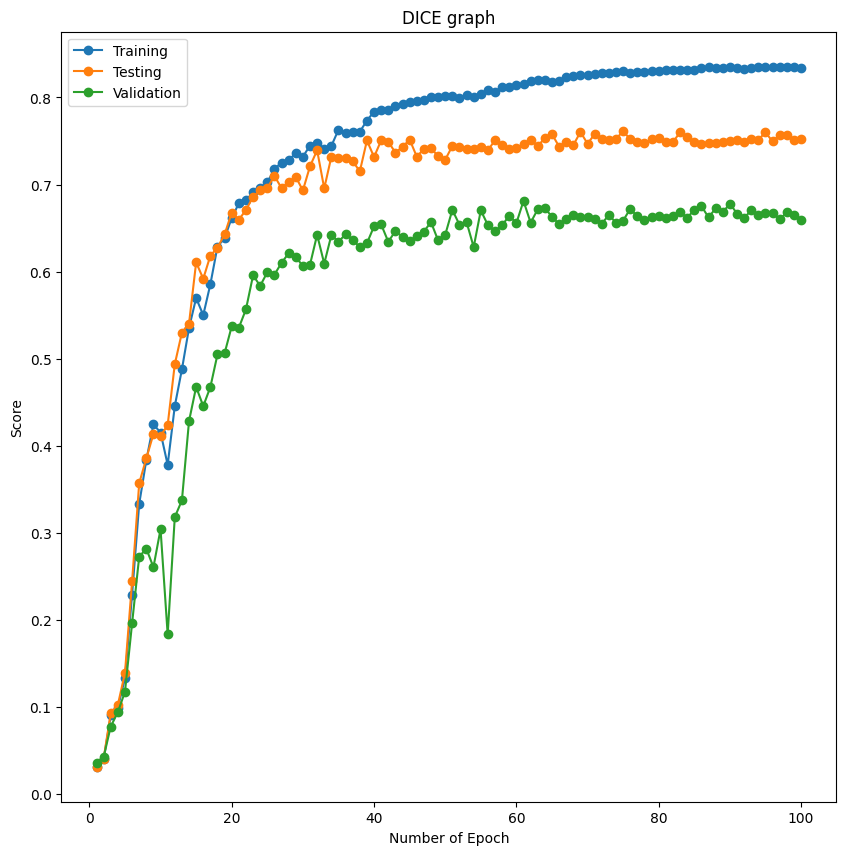

In [68]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("DICE graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_DICE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_DICE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_DICE, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

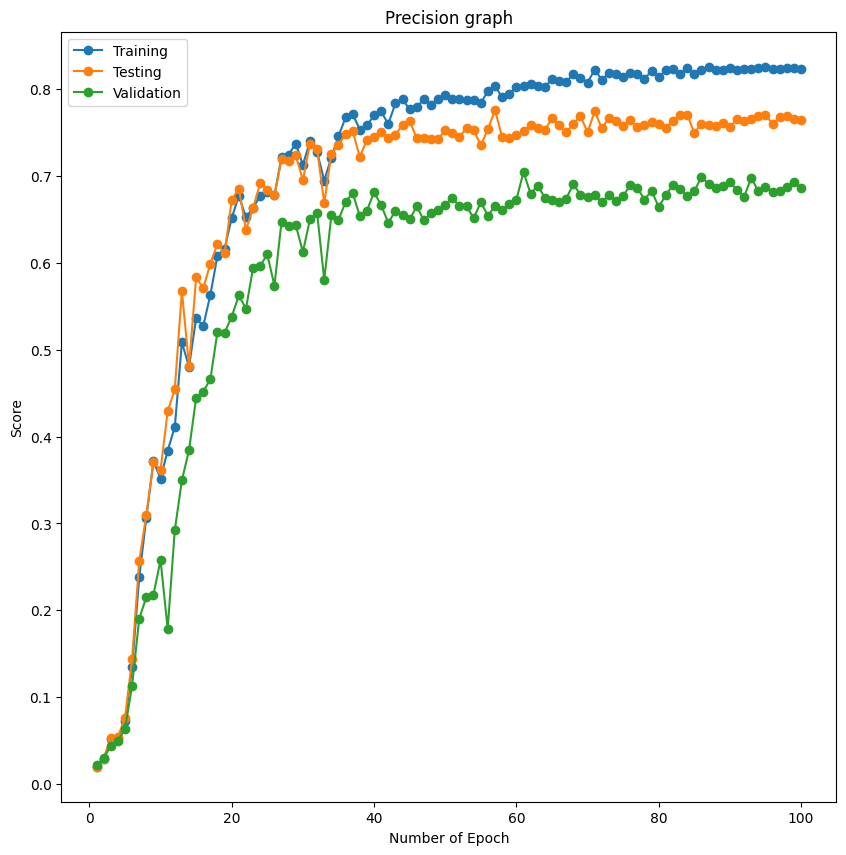

In [69]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Precision graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_PRE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_PRE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_PRE, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

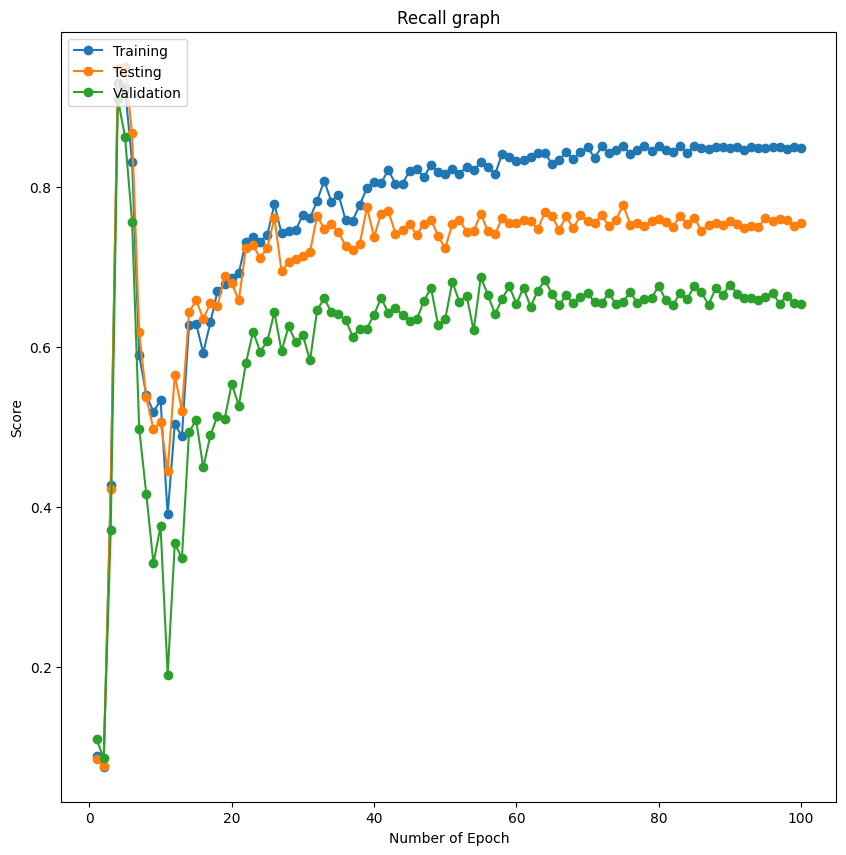

In [70]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Recall graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_REC, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_REC, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_REC, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

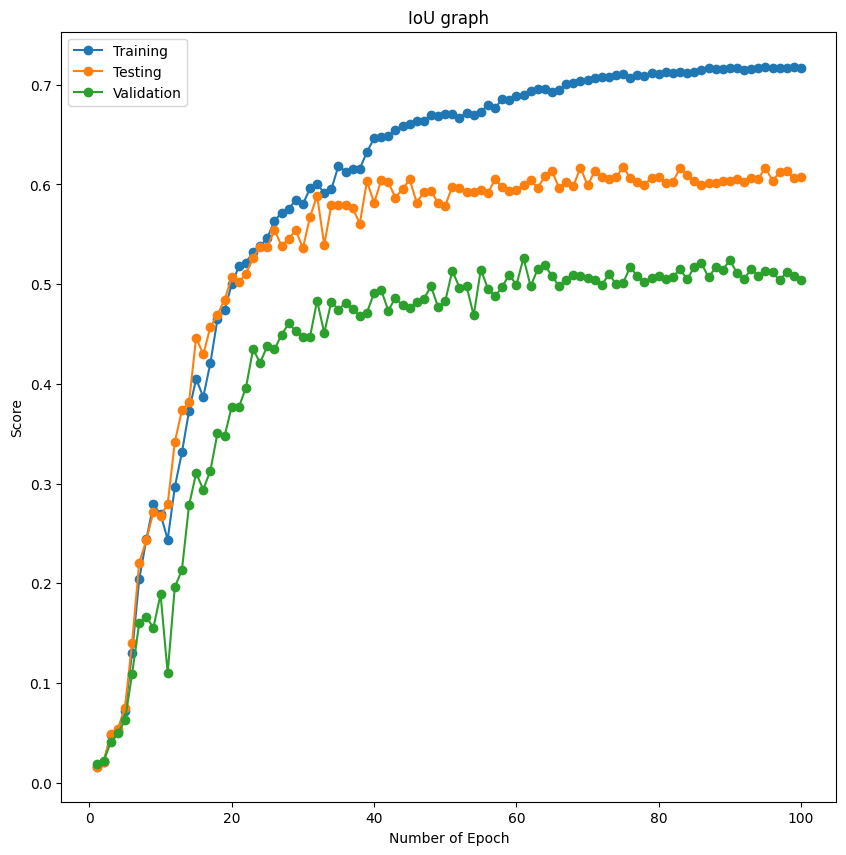

In [71]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("IoU graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_IOU, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_IOU, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_IOU, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

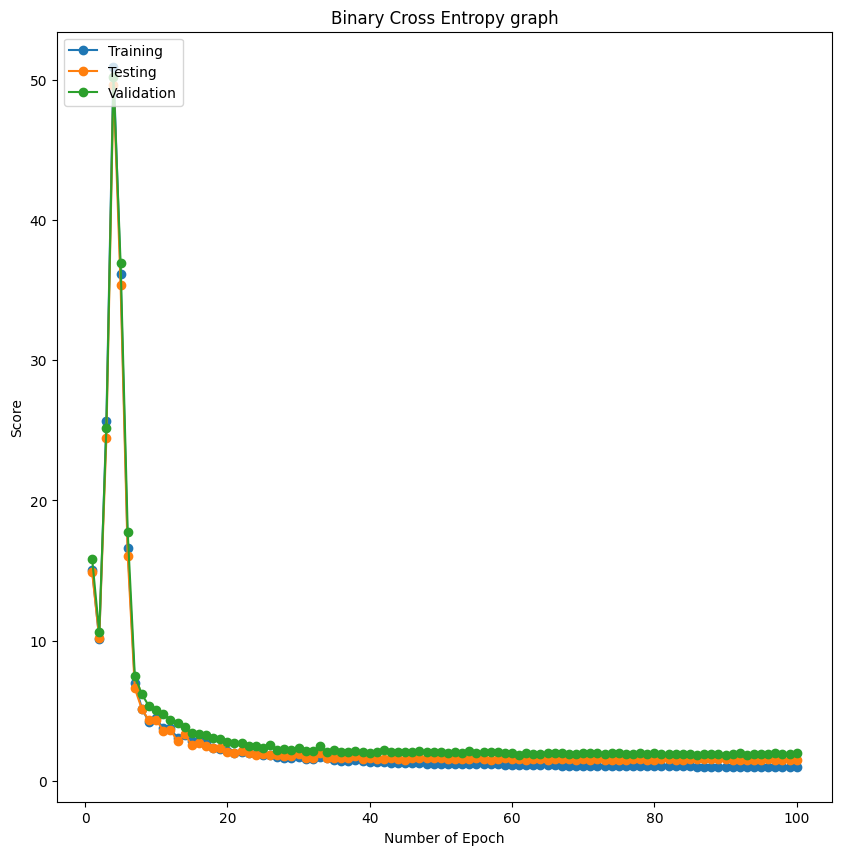

In [72]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Binary Cross Entropy graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_BIN, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_BIN, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_BIN, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

In [73]:
# Iterate over training images

b = "Evaluation training Loading "
for i in range(0, trainImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(haar_wave(X_train[i])).type(dtype)
    targets = Variable(y_train[i].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each training image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())

# Iterate over testing images
b = "Evaluation test Loading "
for i in range(trainImages, trainImages + testImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(haar_wave(X_test[i - trainImages])).type(dtype)
    targets = Variable(y_test[i - trainImages].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each testing image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())
    
# Iterate over validation images
b = "Evaluation val Loading "
for i in range(trainImages + testImages, trainImages + testImages + valImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(haar_wave(X_val[i - trainImages - testImages])).type(dtype)
    targets = Variable(y_val[i - trainImages - testImages].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each validation image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())

Evaluation training Loading  1   Dice  0.8025782 , Precision  0.7275098 , Recall  0.89492106 , IOU  0.67025524 , Binary Cross Entropy  0.93022865
Evaluation training Loading  2   Dice  0.8278851 , Precision  0.81171983 , Recall  0.8447073 , IOU  0.70631737 , Binary Cross Entropy  1.1536525
Evaluation training Loading  3   Dice  0.81803066 , Precision  0.8902959 , Recall  0.7566161 , IOU  0.6920912 , Binary Cross Entropy  0.86367685
Evaluation training Loading  4   Dice  0.85982573 , Precision  0.8554119 , Recall  0.8642854 , IOU  0.75411785 , Binary Cross Entropy  0.89360756
Evaluation training Loading  5   Dice  0.8129362 , Precision  0.72530764 , Recall  0.9246481 , IOU  0.68482935 , Binary Cross Entropy  0.7354443
Evaluation training Loading  6   Dice  0.8185862 , Precision  0.78798604 , Recall  0.85165894 , IOU  0.6928869 , Binary Cross Entropy  0.6486746
Evaluation training Loading  7   Dice  0.82907414 , Precision  0.8209905 , Recall  0.8373186 , IOU  0.70805013 , Binary Cross En

In [74]:
def print_image(x, y, pred_y, slice_no):
    plt.figure()

    # Create subplots with specified number of rows and columns
    f, axarr = plt.subplots(len(slice_no), 3)

    # Iterate over slice numbers
    for i in range(len(slice_no)):
        # Display original image in the first column
        axarr[i][0].imshow(np.resize(x[0][slice_no[i]], (x.shape[2], x.shape[3], 1)))

        # Display ground truth label in the second column
        axarr[i][1].imshow(np.resize(y[0][slice_no[i]], (y.shape[2], y.shape[3], 1)))

        # Display predicted label in the third column
        axarr[i][2].imshow(np.resize(pred_y[0][slice_no[i]], (pred_y.shape[2], pred_y.shape[3], 1)))

<Figure size 640x480 with 0 Axes>

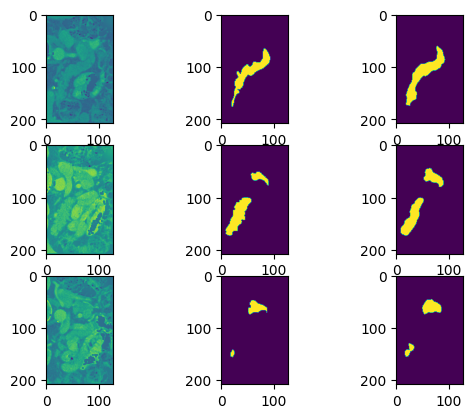

In [75]:
inputs=Variable(haar_wave(X_train[0])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_train[0],y_train[0],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

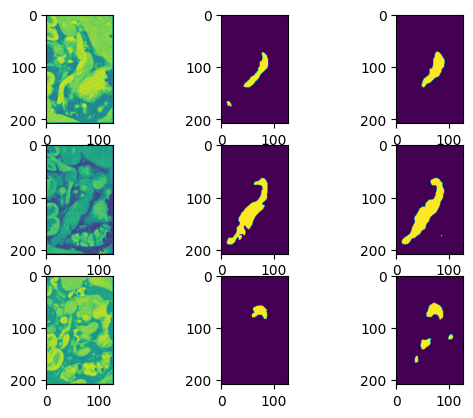

In [76]:
inputs=Variable(haar_wave(X_train[4])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_train[4],y_train[4],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

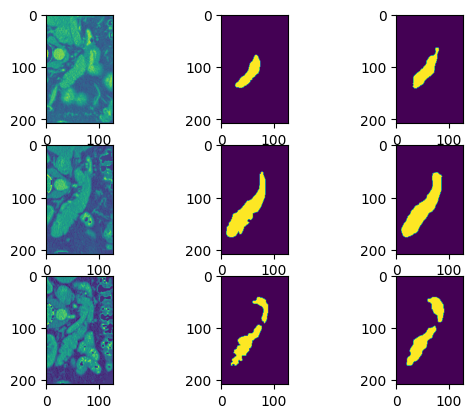

In [77]:
inputs=Variable(haar_wave(X_test[1])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_test[1],y_test[1],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

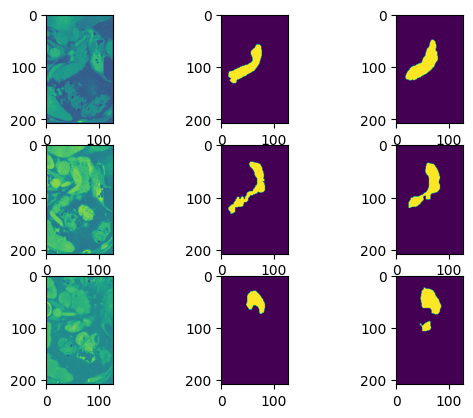

In [78]:
inputs=Variable(haar_wave(X_test[3])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_test[3],y_test[3],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

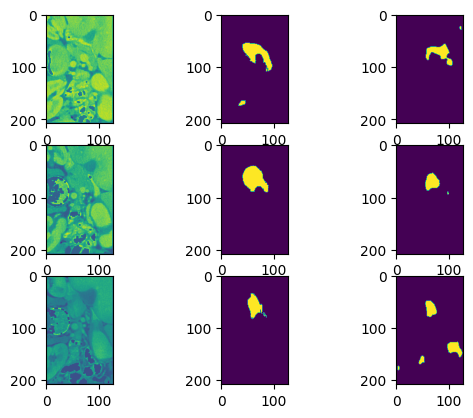

In [79]:
inputs=Variable(haar_wave(X_val[1])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[1],y_val[1],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

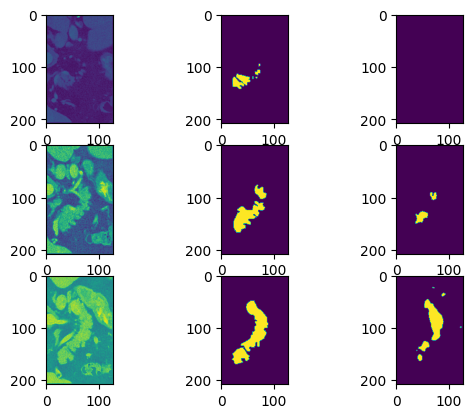

In [80]:
inputs=Variable(haar_wave(X_val[3])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[3],y_val[3],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

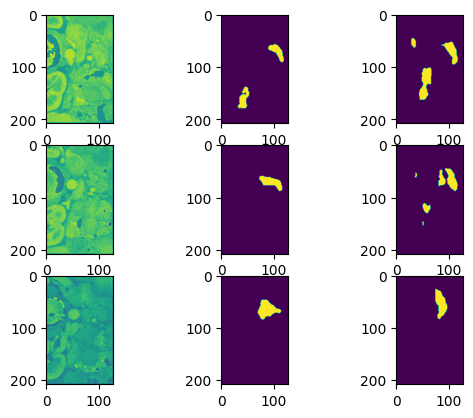

In [81]:
inputs=Variable(haar_wave(X_val[5])).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[5],y_val[5],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])